# TensorRider Algorithm

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorlayer as tl

In [2]:
sess = tf.InteractiveSession()

In [3]:
def rgb2mono(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    # mono = 0.2989 * r + 0.5870 * g + 0.1140 * b
    mono = 0.5 * r + 0.25 * g + 0.25 * b
    return mono

In [4]:
def prepareDataArrays(iterator):
    X = np.zeros(4800)
    y = np.zeros(1)
    recordCounter = 0;

    for string_record in iterator:
        recordCounter += 1

        example = tf.train.Example()
        example.ParseFromString(string_record)
        imageString = (example.features.feature['image'].bytes_list.value[0])
        label = (example.features.feature['label'].int64_list.value[0])

        image = np.fromstring(imageString, dtype=np.uint8)
        image = image.reshape((60, 80, 3))
        image = rgb2mono(image)
        image = image.reshape((4800))

        X = np.vstack((X,image))
        y = np.append(y,label)
        if recordCounter % 100 == 0:
            print(recordCounter,end = '->')

    y = y.reshape((recordCounter + 1,))
#     y = np.round(y / 7) #Downsampling
#     y = y + 6
    y = np.round(y / 12)
    y = y + 3
    return X, y

In [5]:
trainIterator = tf.python_io.tf_record_iterator(path="train.tfrecords")
valIterator = tf.python_io.tf_record_iterator(path="val.tfrecords")
testIterator = tf.python_io.tf_record_iterator(path="test.tfrecords")

# TFRecords -> Arrays

In [6]:
print("\nTrain...")
X_train, y_train = prepareDataArrays(trainIterator)
print("\nVal...")
X_val, y_val = prepareDataArrays(valIterator)
print("\nTest...")
X_test, y_test = prepareDataArrays(testIterator)


Train...
100->

D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


200->300->400->500->600->700->800->900->1000->1100->1200->1300->1400->1500->1600->1700->1800->1900->2000->2100->2200->2300->2400->2500->2600->2700->2800->2900->3000->3100->3200->3300->3400->3500->3600->3700->3800->3900->4000->4100->4200->4300->4400->4500->4600->4700->4800->4900->5000->5100->5200->5300->5400->5500->5600->5700->5800->5900->6000->6100->6200->6300->6400->6500->6600->6700->6800->6900->7000->7100->7200->7300->7400->7500->7600->7700->7800->7900->8000->8100->8200->8300->8400->8500->8600->8700->8800->8900->9000->9100->9200->9300->9400->9500->9600->9700->9800->9900->10000->10100->10200->10300->10400->10500->10600->10700->10800->10900->11000->11100->11200->11300->11400->11500->11600->11700->11800->11900->12000->12100->12200->12300->12400->12500->12600->12700->12800->12900->13000->13100->13200->13300->13400->13500->
Val...
100->200->300->400->500->600->700->800->900->1000->1100->1200->1300->1400->1500->1600->1700->1800->1900->2000->2100->2200->2300->2400->2500->2600->2700->
Test..

# Arrays -> NPZ File

In [7]:
np.savez("arrays.npz", xtr = X_train, ytr = y_train, xval = X_val, yval = y_val, xt = X_test, yt = y_test)

# NPZ File -> Arrays

In [6]:
npRecall = np.load("arrays.npz")
X_train = npRecall["xtr"]
y_train = npRecall["ytr"]
X_val = npRecall["xval"]
y_val = npRecall["yval"]
X_test = npRecall["xt"]
y_test = npRecall["yt"]

# Visualization

(array([4.930e+02, 0.000e+00, 4.565e+03, 0.000e+00, 4.786e+03, 0.000e+00,
        3.352e+03, 0.000e+00, 3.960e+02, 3.000e+00]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <a list of 10 Patch objects>)

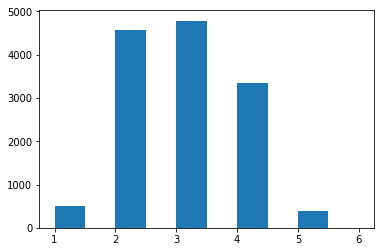

In [12]:
plt.hist(y_train)
# plt.hist(y_val)
# plt.hist(y_test)

# Define the Neural Network

In [13]:
x = tf.placeholder(tf.float32, shape=[None, 4800], name='x')
y_ = tf.placeholder(tf.int64, shape=[None], name='y_')

In [14]:
network = tl.layers.InputLayer(x, name='input')
network = tl.layers.DropoutLayer(network, keep=0.8, name='drop1')
network = tl.layers.DenseLayer(network, 2048, tf.nn.relu, name='relu1')
# network = tl.layers.DropoutLayer(network, keep=0.5, name='drop2')
network = tl.layers.DenseLayer(network, 1024, tf.nn.relu, name='relu2')
# network = tl.layers.DropoutLayer(network, keep=0.5, name='drop3')
network = tl.layers.DenseLayer(network, 1024, tf.nn.relu, name='relu3')
# network = tl.layers.DenseLayer(network, 512, tf.nn.relu, name='relu4')
# network = tl.layers.DenseLayer(network, n_units=13, act=tf.identity, name='output')
network = tl.layers.DenseLayer(network, n_units=7, act=tf.identity, name='output')

[TL] InputLayer  input: (?, 4800)
[TL] DropoutLayer drop1: keep:0.800000 is_fix:False
[TL] DenseLayer  relu1: 2048 relu
[TL] DenseLayer  relu2: 1024 relu
[TL] DenseLayer  relu3: 1024 relu
[TL] DenseLayer  output: 7 identity


In [15]:
y = network.outputs
cost = tl.cost.cross_entropy(y, y_, name='cost')
correct_prediction = tf.equal(tf.argmax(y, 1), y_)
acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
y_op = tf.argmax(tf.nn.softmax(y), 1)

In [16]:
train_params = network.all_params
train_op = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost, var_list=train_params)

In [17]:
tl.layers.initialize_global_variables(sess)

In [18]:
network.print_params()

[TL]   param   0: relu1/W:0            (4800, 2048)       float32_ref (mean: 2.2490896753879497e-06, median: 1.707380943116732e-05, std: 0.08796518296003342)   
[TL]   param   1: relu1/b:0            (2048,)            float32_ref (mean: 0.0               , median: 0.0               , std: 0.0               )   
[TL]   param   2: relu2/W:0            (2048, 1024)       float32_ref (mean: -7.237248064484447e-05, median: -9.516134741716087e-05, std: 0.08792534470558167)   
[TL]   param   3: relu2/b:0            (1024,)            float32_ref (mean: 0.0               , median: 0.0               , std: 0.0               )   
[TL]   param   4: relu3/W:0            (1024, 1024)       float32_ref (mean: -7.022503996267915e-05, median: -8.054064528550953e-05, std: 0.08805258572101593)   
[TL]   param   5: relu3/b:0            (1024,)            float32_ref (mean: 0.0               , median: 0.0               , std: 0.0               )   
[TL]   param   6: output/W:0           (1024, 7)        

In [19]:
network.print_layers()

[TL]   layer   0: drop1/mul:0          (?, 4800)          float32
[TL]   layer   1: relu1/Relu:0         (?, 2048)          float32
[TL]   layer   2: relu2/Relu:0         (?, 1024)          float32
[TL]   layer   3: relu3/Relu:0         (?, 1024)          float32
[TL]   layer   4: output/Identity:0    (?, 7)             float32


# (Optional) Setting up TensorBoard

In [15]:
acc_summ = tf.summary.scalar('acc', acc)  
cost_summ = tf.summary.scalar('cost', cost)  
summary = tf.summary.merge_all()  
writer = tf.summary.FileWriter('./logs')  
writer.add_graph(sess.graph) 

# Start Training

In [20]:
tl.utils.fit(
    sess, network, train_op, cost, X_train, y_train, x, y_, acc=acc, batch_size=100, n_epoch=500, print_freq=5, X_val=X_val, y_val=y_val, eval_train=False, tensorboard=False)

[TL] Start training the network ...
[TL] Epoch 1 of 500 took 2.785300s
[TL]    val loss: 609.712210
[TL]    val acc: 0.696667
[TL] Epoch 5 of 500 took 2.384999s
[TL]    val loss: 189.802146
[TL]    val acc: 0.708889
[TL] Epoch 10 of 500 took 2.306269s
[TL]    val loss: 154.464518
[TL]    val acc: 0.697037
[TL] Epoch 15 of 500 took 2.317661s
[TL]    val loss: 80.050606
[TL]    val acc: 0.722593
[TL] Epoch 20 of 500 took 2.398335s
[TL]    val loss: 59.174184
[TL]    val acc: 0.627037
[TL] Epoch 25 of 500 took 2.381282s
[TL]    val loss: 34.147177
[TL]    val acc: 0.728148
[TL] Epoch 30 of 500 took 2.306662s
[TL]    val loss: 28.615673
[TL]    val acc: 0.723333
[TL] Epoch 35 of 500 took 2.296301s
[TL]    val loss: 20.589285
[TL]    val acc: 0.727037
[TL] Epoch 40 of 500 took 2.287117s
[TL]    val loss: 18.342812
[TL]    val acc: 0.677037
[TL] Epoch 45 of 500 took 2.305817s
[TL]    val loss: 33.733920
[TL]    val acc: 0.567778
[TL] Epoch 50 of 500 took 2.266107s
[TL]    val loss: 27.103077

[TL]    val acc: 0.717037
[TL] Epoch 455 of 500 took 2.283900s
[TL]    val loss: 1.756997
[TL]    val acc: 0.725185
[TL] Epoch 460 of 500 took 2.327770s
[TL]    val loss: 1.609701
[TL]    val acc: 0.742963
[TL] Epoch 465 of 500 took 2.313288s
[TL]    val loss: 2.685584
[TL]    val acc: 0.575556
[TL] Epoch 470 of 500 took 2.257724s
[TL]    val loss: 2.393431
[TL]    val acc: 0.542222
[TL] Epoch 475 of 500 took 2.359835s
[TL]    val loss: 1.988273
[TL]    val acc: 0.597407
[TL] Epoch 480 of 500 took 2.312369s
[TL]    val loss: 1.623719
[TL]    val acc: 0.738148
[TL] Epoch 485 of 500 took 2.342125s
[TL]    val loss: 1.629531
[TL]    val acc: 0.730370
[TL] Epoch 490 of 500 took 2.269831s
[TL]    val loss: 1.635894
[TL]    val acc: 0.728148
[TL] Epoch 495 of 500 took 2.311413s
[TL]    val loss: 1.456880
[TL]    val acc: 0.753333
[TL] Epoch 500 of 500 took 2.307283s
[TL]    val loss: 1.671681
[TL]    val acc: 0.731481
[TL] Total training time: 1178.775795s


# Test the Neural Network

In [21]:
tl.utils.test(sess, network, acc, X_test, y_test, x, y_, batch_size=None, cost=cost)

[TL] Start testing the network ...
[TL]    test loss: 0.898036
[TL]    test acc: 0.756070


# Save the Trained Model

In [22]:
tl.files.save_npz(network.all_params, name='model.npz')
sess.close()

[TL] [*] model.npz saved


# Load the Trained Model

In [12]:
tl.files.load_and_assign_npz(sess=sess, name='model.npz', network=network)

[TL] [*] Load model.npz SUCCESS!


# Controlling TensorRider Using the Generated Model

In [13]:
import cv2
import urllib.request
import numpy as np
import socket
import threading
from time import ctime,sleep
import string

remoteImage = np.array([])
stream = urllib.request.urlopen('http://192.168.73.73:8080/?action=stream&ignored.mjpg')
bytes = bytes()

In [14]:
def Image_Refreshing_Thread():
    global remoteImage
    global stream
    global bytes
    while True:
        bytes += stream.read(1024)
        a = bytes.find(b'\xff\xd8')
        b = bytes.find(b'\xff\xd9')
        if a != -1 and b != -1:
            jpg = bytes[a:b+2]
            bytes = bytes[b+2:]
            i = cv2.imdecode(np.fromstring(jpg, dtype=np.uint8), cv2.IMREAD_COLOR)
            i = rgb2mono(i)
            remoteImage = i.reshape((1,4800))

In [15]:
def Controlling_Thread():
    global remoteImage
    addr=('192.168.73.73',51423)
    s=socket.socket(socket.AF_INET,socket.SOCK_DGRAM)
    while True:
        direction = tl.utils.predict(sess, network, remoteImage, x, y_op, batch_size=None)
        msgCtrl_Udp = str(25) + "," + str((direction[0] - 3) * 15)
#         print(msgCtrl_Udp)
        s.sendto(msgCtrl_Udp.encode('utf-8'), addr)
        sleep(0.1)

In [16]:
RefreshImageThread = threading.Thread(target = Image_Refreshing_Thread)
RefreshImageThread.start()

D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


In [17]:
ControllingThread = threading.Thread(target = Controlling_Thread)
ControllingThread.start()

D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':
